In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer

model_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [35]:
def mean_cl(data, col):
    data = data[col]
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci_low = mean - 1.96 * std_err
    ci_upp = mean + 1.96 * std_err
    return {f'{col}_mean': mean, f'{col}_lwr': ci_low, f'{col}_upr': ci_upp}


def make_acc_df(results):
    results['prob_other'] = 1 - (
        results['lf0_prob'] + results['lf1_prob'] + results['prob_invalid']
    )

    return (
        results.groupby(['n_samples', 'lf0_proportion', 'n_shots'])
        .apply(
            lambda x: pd.Series(
                {
                    **mean_cl(x, 'lf0_prob'),
                    **mean_cl(x, 'lf1_prob'),
                    **mean_cl(x, 'prob_invalid'),
                    **mean_cl(x, 'prob_other'),
                }
            )
        )
        .reset_index()
    )

In [4]:
from plotnine import (
    ggplot,
    aes,
    geom_bar,
    geom_errorbar,
    facet_grid,
    labs,
    theme,
    element_text,
    scale_fill_manual,
    position_stack,
    position_dodge,
)

### prompts

#### zero-shot

> For each ambiguity type, we construct a prompt that provides the ingredients for deriving both LFs. The order of the component sentences is shuffled to avoid biasing the model towards one interpretation or the other. Crucially, the prompt contains no examples of the types of sentences being tested. For example, for PP attachment, the model is given an example of how to parse transitive verbs (“the boy saw the man”), instruments (“the boy saw with the telescope”), and possessives (“the boy with the telescope”), each in isolation. To successfully generalize, the model has to overcome two challenges: first, it must compositionally generalize to compose the ingredients in the prompt into a valid derivation. Secondly, it must recognize the ambiguity and reflect both derivations in its output. For each ambiguity type, we test 200 examples.

Zero-shot prompt construction not in repository.

#### few-shot

> For each ambiguity type, we construct prompts by pairing sentences of the same type with LF0 in some cases, and LF1 in others; we run 100 examples per type, per ratio. Each prompt contains 10 input-LF pairs, and a different prompt is constructed for each test sentence. We vary the number of LF0 sentences in the prompt from 0 to 10 in increments of 1 (e.g. 0 − 100%) and shuffle the prompt sentences to ensure that there is no positional bias.

In [5]:
import numpy as np
import pandas as pd
import random

seed = 80808

random.seed(seed)
np.random.seed(seed)

dataset = pd.read_csv('dataset.csv')


def sample_few_shot_prompt(query, ambiguity_type, lf0_proportion, n_shots=10):
    """Samples a prompt for the given ambiguity type with lf0_proportion * n_shots of LF0 examples"""
    instances = dataset[
        (dataset['type'] == ambiguity_type) & (dataset['surface'] != query)
    ].sample(n=n_shots, random_state=seed)

    _num_lf0 = n_shots * lf0_proportion
    num_lf0 = int(
        np.ceil(_num_lf0) if random.random() < (_num_lf0 % 1) else np.floor(_num_lf0)
    )
    num_lf1 = n_shots - num_lf0

    lf0_examples = instances.head(num_lf0)[['surface', 'lf0']].to_numpy()
    lf1_examples = instances.tail(num_lf1)[['surface', 'lf1']].to_numpy()

    examples = np.concatenate((lf0_examples, lf1_examples))

    np.random.shuffle(examples)

    messages = [
        {
            'role': 'system',
            'content': 'You are a chatbot whose job is to translate what a human user says into what a computer might say.',
        },
    ]

    for surface, lf in examples:
        messages.append({'role': 'user', 'content': surface})
        messages.append({'role': 'assistant', 'content': lf})

    messages.append({'role': 'user', 'content': query})

    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )


def sample_few_shot_prompts(queries, ambiguity_types, lf0_proportion, n_shots=10):
    assert len(queries) == len(ambiguity_types)
    return [
        sample_few_shot_prompt(query, ambiguity_type, lf0_proportion, n_shots)
        for query, ambiguity_type in zip(queries, ambiguity_types)
    ]

In [6]:
prompt = sample_few_shot_prompt(
    query='Ada grabbed the boy with the gloves',
    ambiguity_type='amb_pp',
    lf0_proportion=0.5,
    n_shots=3,
)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a chatbot whose job is to translate what a human user says into what a computer might say.<|eot_id|><|start_header_id|>user<|end_header_id|>

Bill observed Mary with the binoculars<|eot_id|><|start_header_id|>assistant<|end_header_id|>

exists x . exists a . exists e . binoculars(x) AND observed(a) AND agent(a, Bill) AND patient(a, Mary) AND have(e) AND agent(e, Mary) AND patient(e, x)<|eot_id|><|start_header_id|>user<|end_header_id|>

the woman observed Galileo with the spyglass<|eot_id|><|start_header_id|>assistant<|end_header_id|>

exists x . exists y . exists a . exists e . woman(x) AND spyglass(y) AND observed(a) AND agent(a, x) AND patient(a, Galileo) AND have(e) AND agent(e, Galileo) AND patient(e, y)<|eot_id|><|start_header_id|>user<|end_header_id|>

Galileo spotted the man with the binoculars<|eot_id|><|start_header_id|>assistant<|end_header_id|>


### evaluation

> We can canonicalize our LFs, so that logically equivalent formulae with varying syntax are treated as identical: we transform LFs into binary trees, where nodes are ordered alphabetically, and we anonymize variables.

> In the few-shot setting, we are concerned about the level to which the model is capturing the distribution given in the prompt. A core assumption here is that an ideal model would perfectly capture the uncertainty in the given distribution. We consider metrics at two levels of granularity to evaluate this behavior. The first metric we consider measures model performance at the level of the dataset. Intuitively, as we sweep across ratios r ∈ R, we expect the proportion of predicted LFs to match r. For example, when r = 0.10 (meaning that 10% of the prompt examples are LF0 and 90% are LF1) we would expect the model to produce LF0 in roughly 10% of instances. Let yi be the predicted LF for input instance xi. Then the fewshot dataset metric FDM is given by Eq. (2). Intuitively, this measures the difference between the accuracy on each LF and the ratio of that LF; lower is better for FDM, which ranges from 1.0 to 0.0. The second metric measures model performance at the level of individual datapoints. If the model is capturing the distribution in the prompt, then the probability assigned to LF0 should roughly match r, e.g. if r = 0.10, the model should assign P(LF0) ≈ 0.10

In [7]:
from ambiguous_parsing.eval.utils import rerender

lf1 = 'exists x . exists y . exists a . boy(x) AND camera(y) AND spotted(a) AND agent(a, x) AND patient(a, Katherine) AND instrument(a, y)'
lf2 = 'exists z . exists y . exists a . boy(z) AND camera(y) AND spotted(a) AND agent(a, z) AND patient(a, Katherine) AND instrument(a, y)'

assert rerender(lf1, is_fol=True) == rerender(lf2, is_fol=True), 'variable name'

lf1 = 'exists x . exists y . exists a . boy(x) AND camera(y) AND spotted(a) AND agent(a, x) AND patient(a, Katherine) AND instrument(a, y)'
lf2 = 'exists z . exists y . exists a . camera(y) AND boy(z) AND spotted(a) AND agent(a, z) AND patient(a, Katherine) AND instrument(a, y)'

assert rerender(lf1, is_fol=True) == rerender(lf2, is_fol=True), 'conjunct order'

In [8]:
def evaluate_posterior(posterior_approx, gt_lf0, gt_lf1):
    results = {
        'lf0_prob': 0,
        'num_lf0': 0,
        'lf1_prob': 0,
        'num_lf1': 0,
        'prob_invalid': 0,
        'num_invalid': 0,
        'gt_lf0': gt_lf0,
        'gt_lf1': gt_lf1,
    }

    gt_lf0_canonical = rerender(gt_lf0, is_fol=True)
    gt_lf1_canonical = rerender(gt_lf1, is_fol=True)

    for lf, p in posterior_approx.items():
        lf = lf.rstrip('▪')
        try:
            canonical_pred = rerender(lf, is_fol=True)
        except Exception:
            results['prob_invalid'] += p
            results['num_invalid'] += 1
            continue

        if canonical_pred == gt_lf0_canonical:
            results['lf0_prob'] += p
            results['num_lf0'] += 1

        if canonical_pred == gt_lf1_canonical:
            results['lf1_prob'] += p
            results['num_lf1'] += 1

    return results


def evaluate_posteriors(posterior_approxs, gt_lf0s, gt_lf1s, types, queries):
    assert len(posterior_approxs) == len(gt_lf0s) == len(gt_lf1s)
    assert len(gt_lf1s) == len(types) == len(queries)

    items = zip(posterior_approxs, gt_lf0s, gt_lf1s, types, queries)

    all_results = []
    for posterior_approx, gt_lf0, gt_lf1, amb_type, query in items:
        results = evaluate_posterior(
            posterior_approx=posterior_approx, gt_lf0=gt_lf0, gt_lf1=gt_lf1
        )
        results['amb_type'] = amb_type
        results['query'] = query
        results['posterior'] = posterior_approx
        all_results.append(results)

    return all_results

### experiment generation

In [9]:
def sample_experiment(n_examples_per_type, lf0_proportion, n_shots):
    test_cases = []
    for amb_type in dataset['type'].unique():
        if not amb_type.startswith('amb'):
            continue
        test_cases.extend(
            dataset[dataset['type'] == amb_type]
            .sample(n=n_examples_per_type, random_state=seed)
            .to_dict(orient='records')
        )

    queries = [c['surface'] for c in test_cases]
    amb_tps = [c['type'] for c in test_cases]
    gt_lf0s = [c['lf0'] for c in test_cases]
    gt_lf1s = [c['lf1'] for c in test_cases]

    prompts = sample_few_shot_prompts(
        queries, amb_tps, lf0_proportion=lf0_proportion, n_shots=n_shots
    )

    return (prompts, queries, amb_tps, gt_lf0s, gt_lf1s)

In [10]:
conditions = []

n_examples_per_type_list = [50]
lf0_proportion_list = [0, 0.25, 0.5, 0.75, 1]
n_shots_list = [10]

for n_examples_per_type in n_examples_per_type_list:
    for lf0_proportion in lf0_proportion_list:
        for n_shots in n_shots_list:
            prompts, queries, amb_types, gt_lf0s, gt_lf1s = sample_experiment(
                n_examples_per_type, lf0_proportion, n_shots
            )
            conditions.append(
                {
                    'n_examples_per_type': n_examples_per_type,
                    'lf0_proportion': lf0_proportion,
                    'n_shots': n_shots,
                    'data': {
                        'prompts': prompts,
                        'queries': queries,
                        'amb_types': amb_types,
                        'gt_lf0s': gt_lf0s,
                        'gt_lf1s': gt_lf1s,
                    },
                }
            )

### unconstrained LM

In [11]:
import os
import vllm

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

llm = vllm.LLM(
    model=model_name, rope_scaling={'type': 'dynamic', 'factor': 8.0}, max_model_len=7760
)

INFO 08-18 22:01:16 config.py:57] Updating rope_scaling from {'factor': 8.0, 'low_freq_factor': 1.0, 'high_freq_factor': 4.0, 'original_max_position_embeddings': 8192, 'rope_type': 'llama3'} to {'type': 'dynamic', 'factor': 8.0}
INFO 08-18 22:01:16 llm_engine.py:161] Initializing an LLM engine (v0.5.0.post1) with config: model='meta-llama/Meta-Llama-3.1-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling={'type': 'dynamic', 'factor': 8.0}, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=7760, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Meta-Llama-3.1

In [12]:
def run_baseline_experiment(n_samples, prompts, queries, amb_tps, gt_lf0s, gt_lf1s):
    sampling_params = vllm.SamplingParams(
        n=n_samples, temperature=1.0, max_tokens=100, seed=0
    )

    llm_outputs = llm.generate(prompts, sampling_params)

    posterior_approxs = []
    for prompt_output in llm_outputs:
        posterior = {}
        n_outputs = len(prompt_output.outputs)
        for out in prompt_output.outputs:
            pred = out.text.lstrip(' ')
            if pred in posterior:
                posterior[pred] += 1 / n_outputs
            else:
                posterior[pred] = 1 / n_outputs
        posterior_approxs.append(posterior)

    return evaluate_posteriors(
        posterior_approxs=posterior_approxs,
        gt_lf0s=gt_lf0s,
        gt_lf1s=gt_lf1s,
        types=amb_tps,
        queries=queries,
    )

In [13]:
baseline_results = pd.DataFrame()

n_samples_list = [10]

for condition in conditions:
    for n_samples in n_samples_list:
        result = pd.DataFrame(
            run_baseline_experiment(
                n_samples=n_samples,
                prompts=condition['data']['prompts'],
                queries=condition['data']['queries'],
                amb_tps=condition['data']['amb_types'],
                gt_lf0s=condition['data']['gt_lf0s'],
                gt_lf1s=condition['data']['gt_lf1s'],
            )
        )
        result['n_samples'] = n_samples
        result['n_examples_per_type'] = condition['n_examples_per_type']
        result['lf0_proportion'] = condition['lf0_proportion']
        result['n_shots'] = condition['n_shots']

        baseline_results = pd.concat([baseline_results, result], ignore_index=True)

Processed prompts: 100%|██████████| 250/250 [00:37<00:00,  6.63it/s, est. speed input: 4243.33 toks/s, output: 2709.40 toks/s]


In [14]:
baseline_results['prob_other'] = 1 - (
    baseline_results['lf0_prob']
    + baseline_results['lf1_prob']
    + baseline_results['prob_invalid']
)

In [15]:
baseline_results.to_csv('baseline_results_new_prompt.csv', index=False)

### genparse

In [19]:
os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'

##### grammar

In [20]:
grammar = """
start: start_sent

start_sent: quant " " var " . " (quant " " var " . ")* sent
quant: "exists" | "forall"
sent: "( " sent " )"
| sent " " conn " " sent
| expr "(" var ")"
| expr "(" var ", " var ")"
| expr "(" var ", " const ")"

conn: "AND" | "OR"

var: "x" | "y" | "z" | "a" | "e" | "i"

expr: "boy" | "girl" | "man" | "woman" | "bird" | "cat" | "dog" | "fish" | "cow" | "elephant" | "book" | "rock" | "table" | "cup" | "crayon" | "telescope" | "binoculars" | "camera" | "spyglass" | "gloves" | "mittens" | "ovenmitts" | "pyjamas" | "pants" | "sweater" | "hat" | "pyjamas" | "pants" | "binoculars" | "mittens" | "ovenmitts" | "gloves" | "saw" | "observed" | "spotted" | "spied" | "picked_up" | "grabbed" | "held" | "lifted" | "heard" | "listened" | "chased" | "followed" | "called" | "ate" | "drank" | "slept" | "walked" | "left" | "played" | "moved" | "drew" | "napped" | "waved" | "smiled" | "lept" | "frowned" | "shouted" | "agent" | "patient" | "instrument" | "have"
const: "Galileo" | "Marie" | "Sherlock" | "Ada" | "Alan" | "Katherine" | "Watson" | "Adele" | "Bill" | "Mary"
"""

In [21]:
from genparse.util import lark_guide

guide = lark_guide(grammar)

In [22]:
# check coverage

from genparse import EOS
import concurrent.futures
from tqdm import tqdm

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'

n_workers = 10
examples = np.concatenate((dataset['lf0'].to_numpy(), dataset['lf1'].dropna().to_numpy()))


def initialize_worker():
    global guide
    guide = lark_guide(grammar)


def parse_example(example):
    v = guide.eos in guide.p_next(example)
    if not v:
        print(example)
    return (v, example)


with concurrent.futures.ProcessPoolExecutor(
    initializer=initialize_worker, max_workers=n_workers
) as executor:
    with tqdm(total=len(examples)) as progress_bar:
        results = []
        futures = [executor.submit(parse_example, ex) for ex in examples]

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            results.append(result)
            progress_bar.update(1)

  0%|          | 0/74328 [00:00<?, ?it/s]

100%|██████████| 74328/74328 [01:40<00:00, 742.53it/s] 


#### inference

In [23]:
max_num_particles = 250
n_processes = 10
max_tokens = 100

from genparse.util import lark_guide

guide = lark_guide(grammar)

from genparse.experimental.batch_inference import BatchVLLM
from genparse.lm import VirtualTokenizedLLM

batch_llm = BatchVLLM(VirtualTokenizedLLM(llm.llm_engine))

from genparse.experimental.batch_inference import ParallelCharacterProposal

parallel_proposal = ParallelCharacterProposal(
    llm=batch_llm.llm,
    guide=guide,
    num_processes=n_processes,
    max_n_particles=max_num_particles,
    seed=seed,
)

from genparse.experimental.batch_inference import BatchStepModel

step_model = BatchStepModel(
    batch_proposal=parallel_proposal, batch_llm=batch_llm, max_tokens=max_tokens
)

In [24]:
from genparse.experimental.batch_inference import smc
import json


def run_genparse_experiment(
    n_particles,
    prompts,
    queries,
    amb_tps,
    gt_lf0s,
    gt_lf1s,
    out_file,
    ess_threshold=0.5,
    uniform_weights=False,
):
    posterior_approxs = []
    for i, prompt in tqdm(enumerate(prompts)):
        step_model.set_prompt(prompt)
        posterior = smc(
            step_model,
            n_particles=n_particles,
            ess_threshold=ess_threshold,
            return_record=True,
        )

        if uniform_weights:
            posterior = ParticleApproximation(
                particles=[p._replace(log_weight=0) for p in posterior.particles]
            )

        posterior_approxs.append(posterior.finalize(eos='▪').posterior)
        out = {
            'record': posterior.record,
            'query': queries[i],
            'prompt': prompt,
            'amb_type': amb_tps[i],
            'gt_lf0': gt_lf0s[i],
            'gt_lf1': gt_lf1s[i],
        }
        print(json.dumps(out), file=out_file)

    return evaluate_posteriors(
        posterior_approxs=posterior_approxs,
        gt_lf0s=gt_lf0s,
        gt_lf1s=gt_lf1s,
        types=amb_tps,
        queries=queries,
    )

In [25]:
genparse_results = pd.DataFrame()

n_particles_list = [10]

out_file = open('genparse_records_2.jsonl', 'w')

for condition in conditions:
    if condition['n_shots'] != 10:
        continue
    for n_particles in n_particles_list:
        result = pd.DataFrame(
            run_genparse_experiment(
                n_particles=n_particles,
                prompts=condition['data']['prompts'],
                queries=condition['data']['queries'],
                amb_tps=condition['data']['amb_types'],
                gt_lf0s=condition['data']['gt_lf0s'],
                gt_lf1s=condition['data']['gt_lf1s'],
                out_file=out_file,
            )
        )
        result['n_samples'] = n_particles
        result['n_examples_per_type'] = condition['n_examples_per_type']
        result['lf0_proportion'] = condition['lf0_proportion']
        result['n_shots'] = condition['n_shots']

        genparse_results = pd.concat([genparse_results, result], ignore_index=True)

0it [00:00, ?it/s]

250it [06:28,  1.56s/it]
250it [06:32,  1.57s/it]
250it [06:35,  1.58s/it]
250it [06:49,  1.64s/it]
167it [04:46,  2.06s/it]/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/arsenal/maths/util.py:447: RuntimeWarning: invalid value encountered in subtract
/home/lebrunb/genparse/genparse/experimental/batch_inference/steer.py:96: RuntimeWarning: divide by zero encountered in log
250it [06:53,  1.66s/it]


/var/tmp/ipykernel_734811/2563407782.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


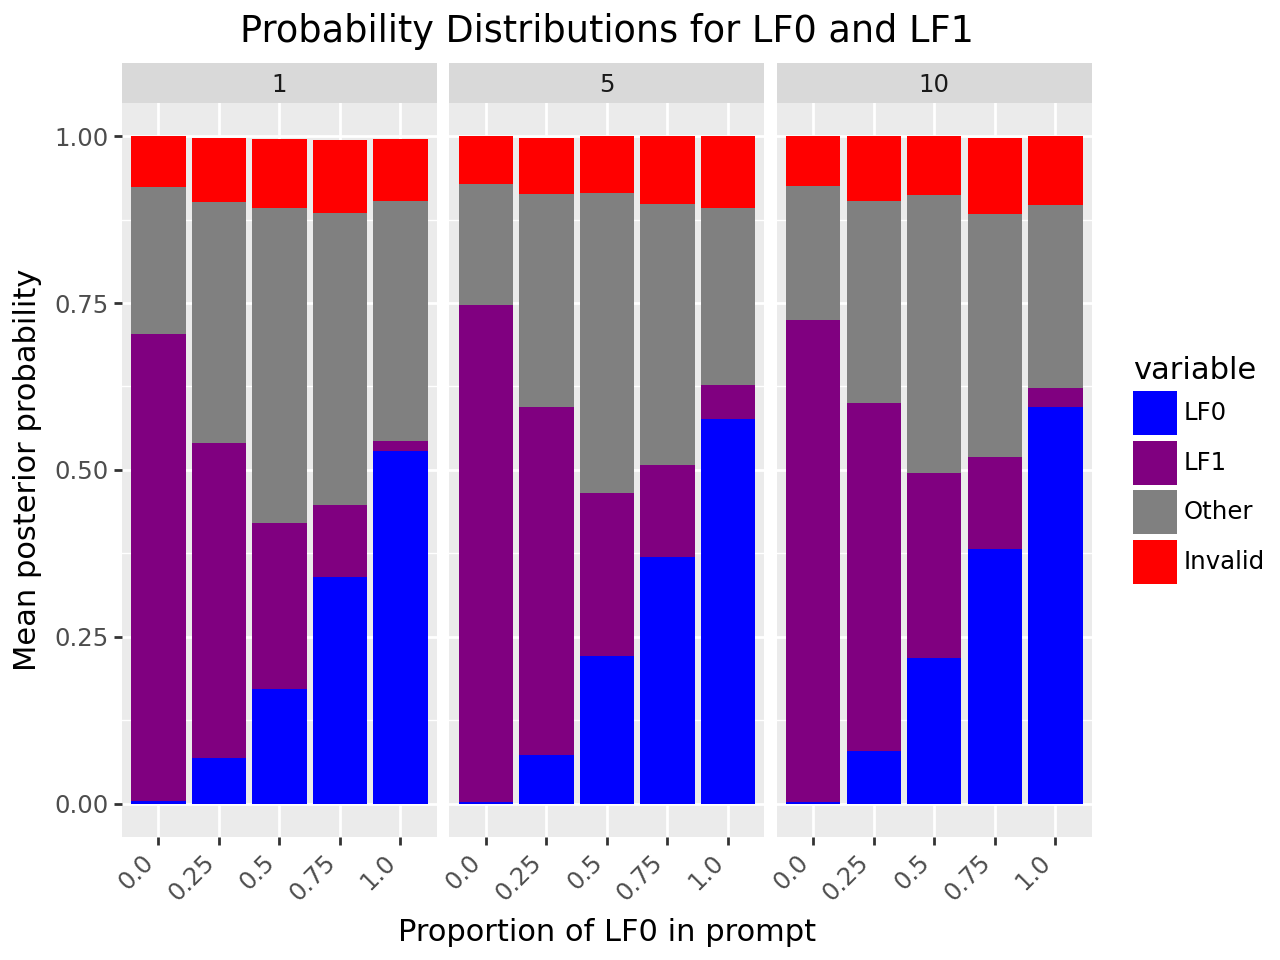

In [19]:
genparse_results['prob_other'] = 1 - (
    genparse_results['lf0_prob']
    + genparse_results['lf1_prob']
    + genparse_results['prob_invalid']
)

accs_genparse = (
    genparse_results.groupby(['n_samples', 'lf0_proportion', 'n_shots'])
    .apply(
        lambda x: pd.Series(
            {
                **mean_cl(x, 'lf0_prob'),
                **mean_cl(x, 'lf1_prob'),
                **mean_cl(x, 'prob_invalid'),
                **mean_cl(x, 'prob_other'),
            }
        )
    )
    .reset_index()
)

df_long = pd.melt(
    accs_genparse,
    id_vars=['n_samples', 'lf0_proportion', 'n_shots'],
    value_vars=['lf0_prob_mean', 'lf1_prob_mean', 'prob_invalid_mean', 'prob_other_mean'],
    var_name='variable',
    value_name='prob_mean',
)

df_long['variable'] = df_long['variable'].map(
    {
        'lf0_prob_mean': 'LF0',
        'lf1_prob_mean': 'LF1',
        'prob_invalid_mean': 'Invalid',
        'prob_other_mean': 'Other',
    }
)

df_long['variable'] = pd.Categorical(
    df_long['variable'], categories=['LF0', 'LF1', 'Other', 'Invalid'], ordered=True
)

p = (
    ggplot(df_long, aes(x='factor(lf0_proportion)', y='prob_mean', fill='variable'))
    + geom_bar(stat='identity', position=position_stack(reverse=True))
    + facet_grid('~ n_samples')
    + labs(
        title='Probability Distributions for LF0 and LF1',
        x='Proportion of LF0 in prompt',
        y='Mean posterior probability',
    )
    + scale_fill_manual(
        values={'LF0': 'blue', 'LF1': 'purple', 'Invalid': 'red', 'Other': 'grey'}
    )
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

p.show()

In [29]:
genparse_results.to_csv('genparse_results_new.csv', index=False)

In [27]:
from genparse.experimental.batch_inference.steer import ParticleApproximation


def run_local_poe_experiment(
    n_particles, prompts, queries, amb_tps, gt_lf0s, gt_lf1s, out_file
):
    posterior_approxs = []
    for i, prompt in tqdm(enumerate(prompts)):
        step_model.set_prompt(prompt)
        posterior = smc(
            step_model, n_particles=n_particles, return_record=True, ess_threshold=0
        )

        posterior = ParticleApproximation(
            particles=[p._replace(log_weight=0) for p in posterior.particles]
        )

        posterior_approxs.append(posterior.finalize(eos='▪').posterior)

        out = {
            'record': posterior.record,
            'query': queries[i],
            'prompt': prompt,
            'amb_type': amb_tps[i],
            'gt_lf0': gt_lf0s[i],
            'gt_lf1': gt_lf1s[i],
        }

        print(json.dumps(out), file=out_file)

    return evaluate_posteriors(
        posterior_approxs=posterior_approxs,
        gt_lf0s=gt_lf0s,
        gt_lf1s=gt_lf1s,
        types=amb_tps,
        queries=queries,
    )

In [42]:
local_results = pd.DataFrame()

n_particles_list = [10]

out_file = open('local_records.jsonl', 'w')

for condition in conditions:
    if condition['n_shots'] != 10:
        continue
    for n_particles in n_particles_list:
        result = pd.DataFrame(
            run_local_poe_experiment(
                n_particles=n_particles,
                prompts=condition['data']['prompts'],
                queries=condition['data']['queries'],
                amb_tps=condition['data']['amb_types'],
                gt_lf0s=condition['data']['gt_lf0s'],
                gt_lf1s=condition['data']['gt_lf1s'],
                out_file=out_file,
            )
        )
        result['n_samples'] = n_particles
        result['n_examples_per_type'] = condition['n_examples_per_type']
        result['lf0_proportion'] = condition['lf0_proportion']
        result['n_shots'] = condition['n_shots']

        local_results = pd.concat([local_results, result], ignore_index=True)

250it [07:12,  1.73s/it]
250it [06:45,  1.62s/it]
250it [06:42,  1.61s/it]
250it [07:46,  1.87s/it]
250it [06:59,  1.68s/it]


In [43]:
local_results.to_csv('local_results.csv', index=False)

### compare results

In [54]:
baseline_accs = make_acc_df(baseline_results)
genparse_accs = make_acc_df(genparse_results)
localpoe_accs = make_acc_df(local_results)

baseline_accs['method'] = 'unconstrained'
genparse_accs['method'] = 'genparse'
localpoe_accs['method'] = 'local'

accs = pd.concat([baseline_accs, genparse_accs, localpoe_accs], ignore_index=True)

/var/tmp/ipykernel_812301/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/tmp/ipykernel_812301/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/tmp/ipykernel_812301/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

In [55]:
accs

,n_samples,lf0_proportion,n_shots,lf0_prob_mean,lf0_prob_lwr,lf0_prob_upr,lf1_prob_mean,lf1_prob_lwr,lf1_prob_upr,prob_invalid_mean,prob_invalid_lwr,prob_invalid_upr,prob_other_mean,prob_other_lwr,prob_other_upr,method
0,10,0.00,10,0.000000,0.000000,0.000000,0.535200,0.485547,0.584853,0.335200,0.289613,0.380787,0.129600,0.106741,0.152459,unconstrained
1,10,0.25,10,0.068400,0.045515,0.091285,0.344800,0.302742,0.386858,0.340800,0.296378,0.385222,0.246000,0.212848,0.279152,unconstrained
2,10,0.50,10,0.186400,0.146107,0.226693,0.159600,0.128376,0.190824,0.334800,0.290612,0.378988,0.319200,0.280786,0.357614,unconstrained
3,10,0.75,10,0.277200,0.231931,0.322469,0.067600,0.046204,0.088996,0.356400,0.311325,0.401475,0.298800,0.261079,0.336521,unconstrained
4,10,1.00,10,0.484400,0.433913,0.534887,0.008800,0.002826,0.014774,0.336800,0.290510,0.383090,0.170000,0.141814,0.198186,unconstrained
5,10,0.00,10,0.001414,-0.000950,0.003777,0.735581,0.691707,0.779455,0.082223,0.055336,0.109109,0.180783,0.146653,0.214913,genparse
6,10,0.25,10,0.079147,0.052407,0.105887,0.531459,0.482854,0.580064,0.086184,0.061295,0.111072,0.303210,0.261960,0.344460,genparse
7,10,0.50,10,0.234588,0.191739,0.277438,0.270331,0.227733,0.312929,0.087256,0.060284,0.114228,0.407825,0.362506,0.453144,genparse
8,10,0.75,10,0.333816,0.284667,0.382966,0.135010,0.099867,0.170154,0.108999,0.080641,0.137357,0.422174,0.376293,0.468056,genparse
9,10,1.00,10,0.615236,0.564343,0.666128,0.049296,0.023692,0.074900,0.097269,0.068638,0.125901,0.235530,0.195199,0.275861,genparse


In [95]:
df_long = pd.melt(
    accs,
    id_vars=['n_samples', 'lf0_proportion', 'n_shots', 'method'],
    value_vars=['lf0_prob_mean', 'lf1_prob_mean', 'prob_invalid_mean', 'prob_other_mean'],
    var_name='Semantic value',
    value_name='prob_mean',
)

df_long['Semantic value'] = df_long['Semantic value'].map(
    {
        'lf0_prob_mean': 'LF0',
        'lf1_prob_mean': 'LF1',
        'prob_invalid_mean': 'Invalid',
        'prob_other_mean': 'Other',
    }
)

df_long['lwr'] = pd.melt(
    accs,
    id_vars=['n_samples', 'lf0_proportion', 'n_shots', 'method'],
    value_vars=['lf0_prob_lwr', 'lf1_prob_lwr', 'prob_invalid_lwr', 'prob_other_lwr'],
    value_name='lwr',
)['lwr']

df_long['upr'] = pd.melt(
    accs,
    id_vars=['n_samples', 'lf0_proportion', 'n_shots', 'method'],
    value_vars=['lf0_prob_upr', 'lf1_prob_upr', 'prob_invalid_upr', 'prob_other_upr'],
    value_name='upr',
)['upr']

df_long['Semantic value'] = pd.Categorical(
    df_long['Semantic value'], categories=['LF0', 'LF1', 'Other', 'Invalid'], ordered=True
)

/var/tmp/ipykernel_812301/3668143735.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


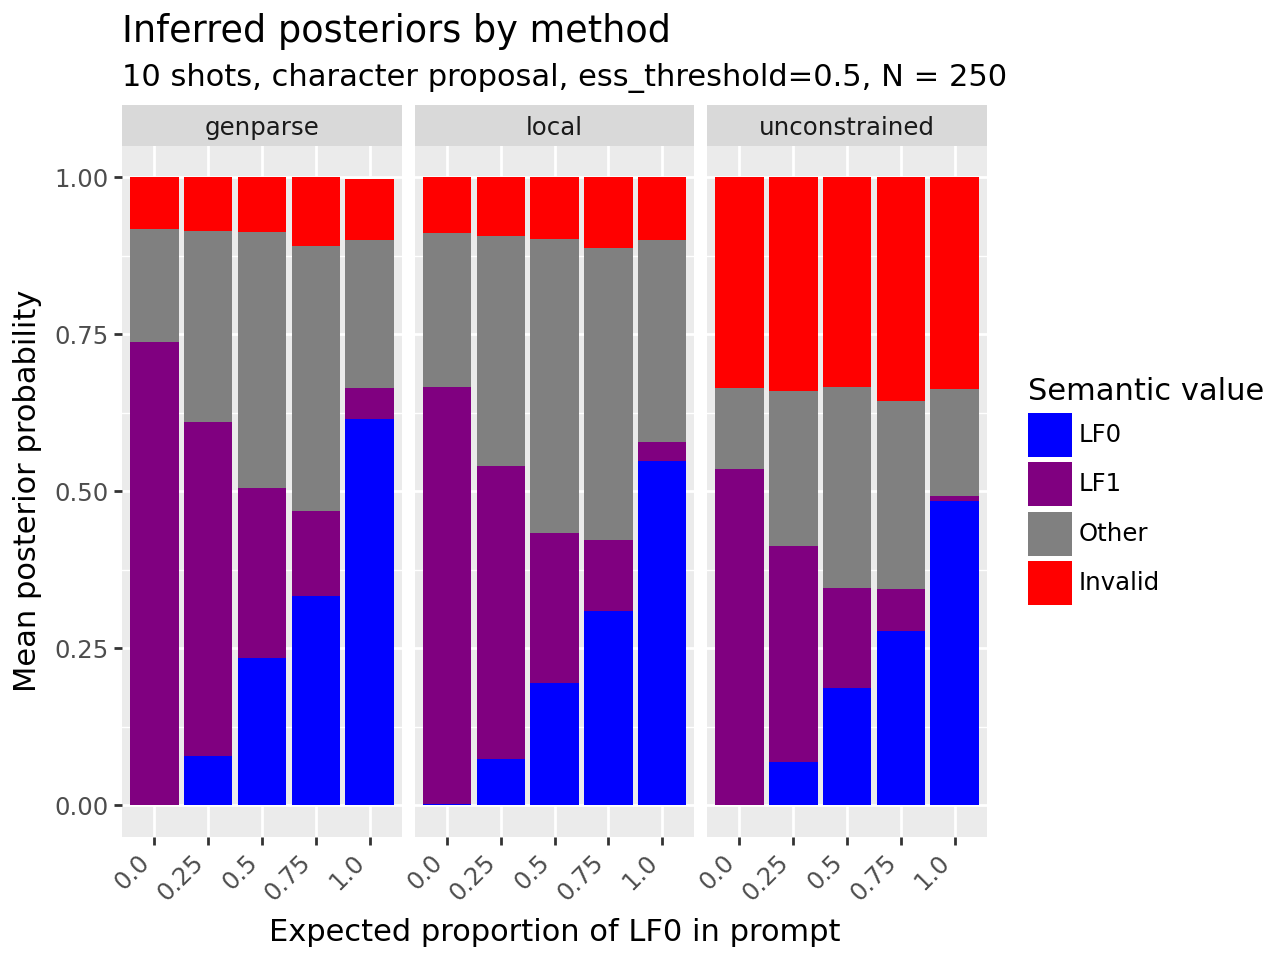

In [127]:
p = (
    ggplot(df_long, aes(x='factor(lf0_proportion)', y='prob_mean', fill='Semantic value'))
    + geom_bar(stat='identity', position=position_stack(reverse=True))
    + facet_grid('~ method')
    + labs(
        title='Inferred posteriors by method',
        subtitle='10 shots, character proposal, ess_threshold=0.5, N = 250',
        x='Expected proportion of LF0 in prompt',
        y='Mean posterior probability',
    )
    + scale_fill_manual(
        values={'LF0': 'blue', 'LF1': 'purple', 'Invalid': 'red', 'Other': 'grey'}
    )
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

p.show()

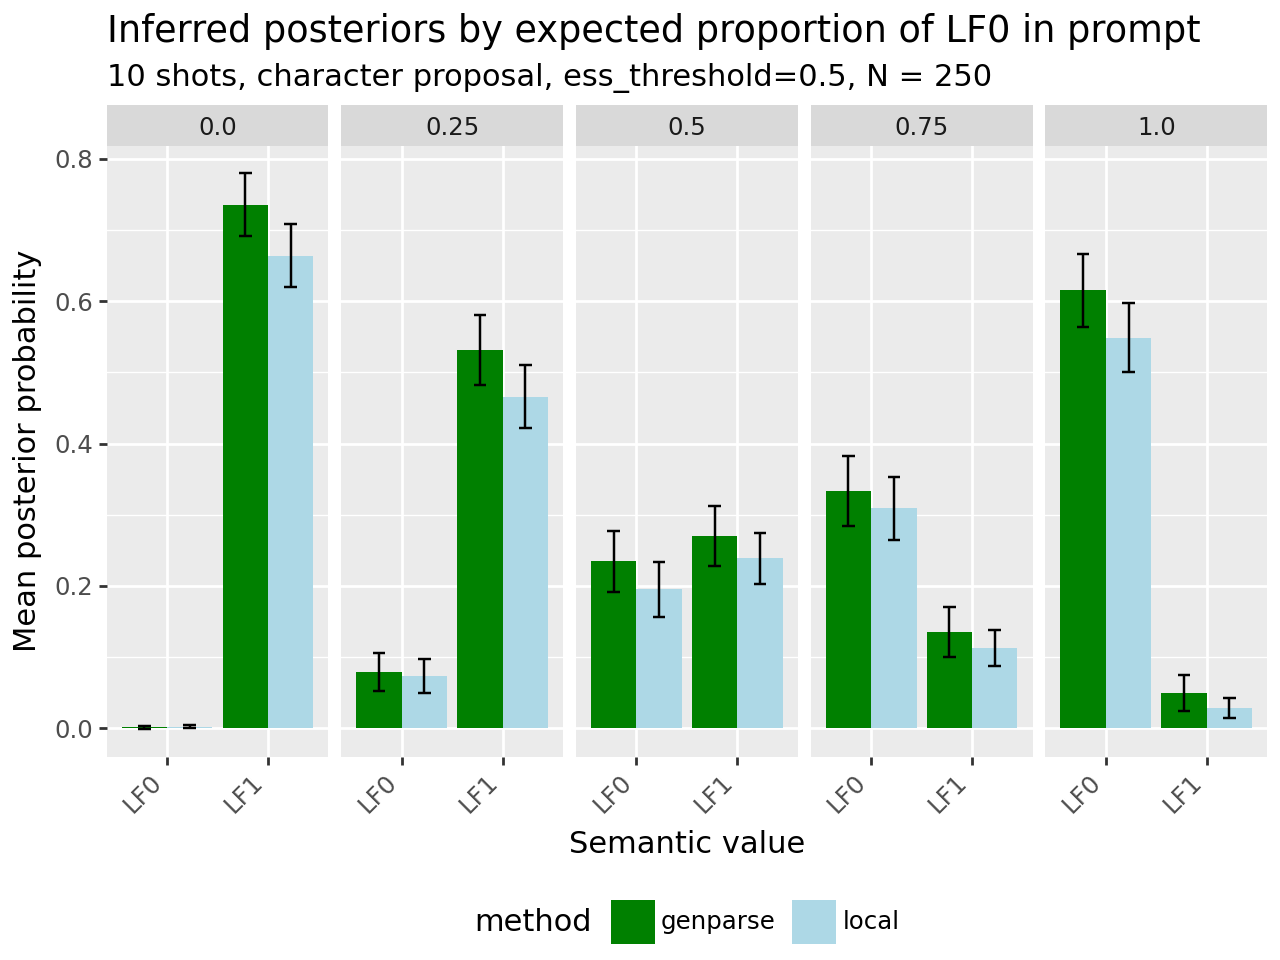

In [126]:
df_long_subset = df_long[(df_long['method'] != 'unconstrained')]
df_long_subset = df_long_subset[
    (df_long_subset['Semantic value'] != 'Other')
    & (df_long_subset['Semantic value'] != 'Invalid')
]

dodge_width = 0.9

p = (
    ggplot(df_long_subset, aes(x='Semantic value', y='prob_mean', fill='method'))
    + geom_bar(stat='identity', position=position_dodge(width=dodge_width))
    + geom_errorbar(
        aes(ymin='lwr', ymax='upr'),
        position=position_dodge(width=dodge_width),
        width=0.25,
    )
    + facet_grid('~ lf0_proportion')
    + labs(
        title='Inferred posteriors by expected proportion of LF0 in prompt',
        subtitle='10 shots, character proposal, ess_threshold=0.5, N = 250',
        x='Semantic value',
        y='Mean posterior probability',
    )
    + scale_fill_manual(
        values={
            'genparse': 'green',
            'local': 'lightblue',
        }
    )
    + theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='bottom')
)

p.show()